In [1]:
#@title import
import pandas as pd
import numpy as np
import random
# Neural network
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import SGD 
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import math

from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN


oversampling_method = 'ADASYN'

seed_value = 120
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#@title Dataset

path_trainset = r"C:\Users\michi\Downloads\RenK trainset..tsv"
path_testset = r"C:\Users\michi\Downloads\RenK testset.tsv"


train_reshaped = pd.read_csv(path_trainset, sep='\t')
test_reshaped = pd.read_csv(path_testset, sep='\t')
train_reshaped = train_reshaped.drop(columns=train_reshaped.columns[0], axis=1)
test_reshaped = test_reshaped.drop(columns=test_reshaped.columns[0], axis=1)
train_reshaped = train_reshaped.values
test_reshaped = test_reshaped.values

div = 16

train = train_reshaped.reshape(train_reshaped.shape[0], train_reshaped.shape[1] // div, div)
test = test_reshaped.reshape(test_reshaped.shape[0], test_reshaped.shape[1] // div, div)

y_train = train[:, 0:1, 1:2].astype(np.float32).reshape(-1)



if oversampling_method == 'SMOTE':
    #SMOTE
    # Reshape train to 2D matrix
    train_2d = train.reshape(train.shape[0], -1)

    # Apply SMOTE oversampling  
    smote = SMOTE(sampling_strategy=0.95)  # Set the desired ratio of minority to majority class
    train_resampled_2d, y_train_resampled_SMOTE = smote.fit_resample(train_2d, y_train)

    # Reshape train_resampled back to the original shape
    train_resampled_SMOTE = train_resampled_2d.reshape(-1, train.shape[1], train.shape[2])

    train = train_resampled_SMOTE
else:

    #ADASYN
    # Reshape X_train to 2D matrix
    train_2d = train.reshape(train.shape[0], -1)

    # Apply ADASYN oversampling
    adasyn = ADASYN(sampling_strategy=0.95)  # Set the desired ratio of minority to majority class
    train_resampled_2d, y_train_resampled_ADASYN = adasyn.fit_resample(train_2d, y_train)

    train_resampled_ADASYN = train_resampled_2d.reshape(-1, train.shape[1], train.shape[2])

    train = train_resampled_ADASYN

# Prepare train data
# True labels
y_train = torch.tensor(train[:, 0:1, 1:2]).float()
y_train = torch.reshape(y_train, (-1,))
y_train = y_train

# Predicted labels
X_train = torch.tensor(train[:, :, 2:14]).float()

# Test y and X
# True labels
y_test = torch.tensor(test[:, 0:1, 1:2]).float()       #Gives error. Check this
y_test = torch.reshape(y_test, (-1,))      
y_test = y_test.detach().numpy()

desired_conv_frac = 0.5
batch_size = 1024

# Predicted labels
X_test = torch.tensor(test[:, :, 2:14]).float() #Gives error

# Split data into stratified batches on conversions
id_conv = train[:, 0, 0:2]
batch_train = []
batch_size = 1024

# Create stratified batches
while batch_size < id_conv.shape[0]:
  # Get stratified sample of train data
  id_conv, curr_batch = train_test_split(id_conv, 
                                         test_size=batch_size/id_conv.shape[0], 
                                         random_state=22, shuffle=True, 
                                         stratify=id_conv[:, 1])
  indices = np.isin(train[:, 0, 0], list(curr_batch[:, 0]))

  # Append to batch list
  batch_train.append(torch.tensor(train[indices, :, 1:14]).float())

# Get stratified sample of train data
indices = np.isin(train[:, 0, 0], list(id_conv[:, 0]))

# Append to batch list
batch_train.append(torch.tensor(train[indices, :, 1:14]).float())
batch_test = torch.split(X_test, batch_size)

batch_conversions = []
for i in range(len(batch_train)):
    conversion_count = 0
    for j in range(len(batch_train[i])):
        conversion_count = conversion_count + batch_train[i][j][0][0]
    conversion_ratio = conversion_count / len(batch_train[i])
    batch_conversions.append(conversion_ratio)
    


for i in range(len(batch_train) -1):
    perm = torch.randperm(batch_train[i].size(0))
    batch_train[i] = batch_train[i][perm]

#Correct for batch_size 1025 of batch 9
for i in range(len(batch_train)-1):
    first_dim = batch_train[i].shape[0]
    if first_dim != 1024:
        print(i)
        batch_i = batch_train[i]
        new_batch_i = torch.narrow(batch_i, 0, 0, batch_i.size(0)-1)
        batch_train[i] = new_batch_i


number_of_batches = len(batch_train)
batchsize = 1
touchpoints = 20

def correct_order(input):
    batch_train = input
    batch_train_reversed = []
    
    for q in tqdm(range(len(batch_train))):
        if q == len(batch_train)-1:
            break
        else:
            for j in range(batch_size):
                for i in range(touchpoints):
                    if batch_train[q][j][i][1] == 0:
                        index = i
                        seq_length = index - 1
                        break
                rows = batch_train[q][j][:seq_length+1, :]
                rows_reversed = torch.flip(rows, dims=[0])
                batch_train[q][j][:seq_length+1, :] = rows_reversed
            batch_train_reversed.append(batch_train[q])
    
    batch_train_reversed.append(batch_train[len(batch_train)-1])
    return batch_train_reversed

batch_train = correct_order(batch_train)
batch_test = correct_order(batch_test)

print("batch train shape : ",batch_train[0].shape)
print("Y true : ",batch_train[0][:, 0, 0].shape)
print("X  : ",batch_train[0][:, :, 1:].shape)


def positionalencoding2d(d_model, height, width):

    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dimension (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) *
                         -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    
    return pe


class attention(nn.Module):
    def __init__(self,  sequence, touchpoints, embedding_dim):
        super(attention, self).__init__()
        ''' batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12
        '''
        
        self.touchpoints = touchpoints
        self.sequence = sequence
        self.embedding_dim = embedding_dim
        
        self.w1 = torch.nn.Linear(embedding_dim, 2*embedding_dim, bias=True)
        self.w2 = torch.nn.Linear( 2*embedding_dim,1)
        torch.nn.init.xavier_uniform_(self.w1.weight)
        torch.nn.init.xavier_uniform_(self.w2.weight)
        
        self.softmax = nn.Softmax(dim=2)
    
    def forward(self, input): 
        #input shape = [batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12] ex - [2, 287145, 20, 12]
        x = F.tanh(self.w1(input)) #out shape = [2, 287145, 20, 24]
        attention_weights = torch.transpose(self.softmax(self.w2(x) )  , dim0 = 2, dim1=3)    #out shape = [2, 287145, 1, 20]  
        x = torch.matmul(attention_weights,input) #out shape = [2, 287145, 1, 12]
        # out = torch.sum(x, dim=1)
        return x,attention_weights


class Swan(nn.Module):
    def __init__(self,  batchsize, sequence, touchpoints, embedding_dim):
        super(Swan, self).__init__()
        ''' batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12
        '''
        self.batchsize =batchsize
        self.touchpoints = touchpoints
        self.sequence = sequence
        self.embedding_dim = embedding_dim
        self.gamma = nn.parameter.Parameter(torch.ones(1))
        
        self.an1 = attention( sequence, touchpoints, embedding_dim)
        self.an2 = attention( sequence, touchpoints, embedding_dim)
        self.an3 = attention( sequence, touchpoints, embedding_dim)
        self.an4 = attention( sequence, touchpoints, embedding_dim)
        self.an5 = attention(sequence, 4, embedding_dim)
        
        self.dropout = nn.Dropout(0.25)
        
        self.Wc = nn.Linear(embedding_dim, 1, bias = False)
        self.bc = nn.Parameter(torch.ones(batchsize,sequence, 1,1))
        self.sigmoid = nn.Sigmoid()
        
        self.gamma_list = []
        
   
    def forward(self, input): 
        #input shape = batch size = 2,sequence = 287145, touchpoints=20, embedding_dim=12 
        

        pe = positionalencoding2d(sequence, touchpoints, embedding_dim)
        pe = pe.unsqueeze(0)

        input = input + self.gamma*pe

        x1,attention_weights1 = self.an1(input) #out shape= [2, 287145, 1, 12]
        x2,attention_weights2 = self.an2(input) #out shape= [2, 287145, 1, 12]
        x3,attention_weights3 = self.an3(input) #out shape= [2, 287145, 1, 12]
        x4,attention_weights4 = self.an4(input) #out shape= [2, 287145, 1, 12]
        
        x1 = self.dropout(x1)
        x2 = self.dropout(x2)
        x3 = self.dropout(x3)
        x4 = self.dropout(x4)

        x = torch.cat((x1,x2,x3,x4),dim = 2)
        x,vl = self.an5(x)
        
        self.attention_weights1 = attention_weights1
        self.attention_weights2 = attention_weights2
        self.attention_weights3 = attention_weights3
        self.attention_weights4 = attention_weights4
        self.vl = vl
        
        # out = x1+x2+x3+x4 #out shape= [2, 287145, 1, 12]
        out = self.sigmoid( F.relu(self.Wc(x) )+self.bc ) #out shape=([2, 287145, 1, 1])
        # out = torch.where(out>0.5, 1, 0) #out shape=([2, 287145, 1, 1])
        out = torch.squeeze(out,dim = (2,3))

        
        return out,vl,attention_weights1,attention_weights2,attention_weights3,attention_weights4
        

seed_value = 120
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)

batch_size = 1024

alpha = 0.01
beta1 = 0.90
beta2 = 0.98
epsilon = 1e-9
EPOCHS = 7
number_of_batches = 515
num_samples = 1

accuracy_array = np.empty((num_samples, EPOCHS))
predictions_array = np.empty((num_samples, 71680))
F1_Measure_array = np.empty((num_samples, EPOCHS))
precision_array = np.empty((num_samples, EPOCHS))
recall_array = np.empty((num_samples, EPOCHS))
AUC_array = np.empty((num_samples, EPOCHS))
D3_predictions = np.empty((num_samples, EPOCHS, 71680))
    
    
batchsize = 1
sequence = 1024
touchpoints = 20
embedding_dim = 12



for sample in tqdm(range(num_samples)):

    model = Swan(batchsize, sequence, touchpoints, embedding_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=alpha, betas=(beta1, beta2), eps=epsilon)
    lossfn = nn.BCELoss()

    epoch_loss_list = []
    accuracy_list = []
    test_output_list = []
    attention_weights_1_list = []
    attention_weights_2_list = []
    attention_weights_3_list = []
    attention_weights_4_list = []
    vl_list = []
    out_list = []
    gradient_norm_list = []
    gamma_array = np.empty((EPOCHS, number_of_batches-1))


    #____________________________________________________________________________________________________________________________________________________________________________________
    model.train()
    for epoch in tqdm(range(EPOCHS)): # 3 full passes over the data
        model.train()
        epoch_loss = 0
        gradient_norms = []  
    
        attention_weights1_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
        attention_weights2_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
        attention_weights3_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
        attention_weights4_concat = torch.empty((number_of_batches-1), 1024, 1, 20)
        vl_concat = torch.empty((number_of_batches-1), 1024, 1, 4)
        out_concat = torch.empty((number_of_batches-1), 1, 1024)
        gamma_concat = torch.empty((number_of_batches-1), 1, 1024)
    
     
        for data in range(number_of_batches-1): 
            model.zero_grad() 
            Train_inp = torch.unsqueeze(batch_train[data][:, :, 1:], dim = 0).to(device).float()
            y_true = torch.unsqueeze(batch_train[data][:, 0, 0], dim = 0).to(device).float()
        
            out,vl,attention_weights1,attention_weights2,attention_weights3,attention_weights4 = model.forward(Train_inp)

            loss = lossfn(out, y_true)
            loss.backward( retain_graph=True)  
            optimizer.step()  
        
            epoch_loss += loss.item() * y_true.shape[0] / 287145
        
            #Create list of attention weights for every batch
            attention_weights1_concat[data] = attention_weights1
            attention_weights2_concat[data] = attention_weights2
            attention_weights3_concat[data] = attention_weights3
            attention_weights4_concat[data] = attention_weights4
            vl_concat[data] = vl
            out_concat[data] = out
            #gamma_array[epoch][data] = model.gamma.clone().detach().numpy()
        
            gradients = []
            for param in model.parameters():
                if param.grad is not None:
                    gradients.append(param.grad.norm().item())
            gradient_norms.append(sum(gradients))
        
        # Plot the gradient norms
        #average_gradient_norm = sum(gradient_norms) / len(gradient_norms)
        #gradient_norm_list.append(average_gradient_norm)
        
        #plt.figure()
        #plt.plot(gradient_norm_list)
        #plt.title('Gradient Norms')
        #plt.xlabel('Epoch')
        #plt.ylabel('Average Gradient Norm')
        #plt.show()
    
        #Create list of attention weights for every Epoch    
        attention_weights_1_list.append(attention_weights1_concat)
        attention_weights_2_list.append(attention_weights2_concat)
        attention_weights_3_list.append(attention_weights3_concat)
        attention_weights_4_list.append(attention_weights4_concat)
        vl_list.append(vl_concat)
        out_list.append(out_concat)

    

    
        model.eval()
        
        #Print accuracy graph
        test_output_list = []
    
    
        for data in range(len(batch_test)-1):
            test_inp = torch.unsqueeze(batch_test[data], dim = 0).to(device).float()
            (out_test,vl,attention_weights1,attention_weights2,
            attention_weights3,attention_weights4) = model(test_inp)
            test_output_list.append(out_test)

        concat_test_output = torch.cat(test_output_list, dim=1)
        concat_test_output = torch.reshape(concat_test_output, (-1,))
        concat_test_output = concat_test_output.detach().numpy()
        D3_predictions[sample, epoch, :] = concat_test_output
        pred_y_test = concat_test_output
        pred_y_test = np.where(pred_y_test > 0.5, 1, 0)
        concat_test_output = torch.tensor([])

        #Take subset because we cannot enter last (smaller) batch in model
        y_test_subset = y_test[:71680]
        test_acc = accuracy_score(y_test_subset, pred_y_test)
        accuracy_list.append(test_acc)
        accuracy_array[sample][epoch] = test_acc
       
        test_f_measure = f1_score(y_test_subset, pred_y_test, average='weighted')
        F1_Measure_array[sample][epoch] = test_f_measure
        
        test_precision = precision_score(y_test_subset, pred_y_test, average='weighted', zero_division=1)
        precision_array[sample][epoch] = test_precision
        
        test_recall = recall_score(y_test_subset, pred_y_test, average='weighted')
        recall_array[sample][epoch] = test_recall
        
        test_AUC = roc_auc_score(y_test_subset, pred_y_test, average='weighted')
        AUC_array[sample][epoch] = test_AUC
  
    

    test_output_list2 = []

    for data in range(len(batch_test)-1):
        test_inp = torch.unsqueeze(batch_test[data], dim = 0).to(device).float()
        (out_test,vl,attention_weights1,attention_weights2,
        attention_weights3,attention_weights4) = model(test_inp)
        test_output_list.append(out_test)
        test_output_list2.append(out_test)

    concat_test_output = torch.cat(test_output_list, dim=1)
    concat_test_output = torch.reshape(concat_test_output, (-1,))
    concat_test_output = concat_test_output.detach().numpy()
    
    concat_test_output2 = torch.cat(test_output_list2, dim=1)
    concat_test_output2 = torch.reshape(concat_test_output2, (-1,))
    concat_test_output2 = concat_test_output2.detach().numpy()
    
    predictions_array[sample, :] = concat_test_output2
    pred_y_test = np.where(pred_y_test > 0.5, 1, 0)
    concat_test_output = torch.tensor([])

    #Take subset because we cannot enter last (smaller) batch in model
    y_test_subset = y_test[:71680]

    test_acc = accuracy_score(y_test_subset, pred_y_test)
    #print("Accuracy:", test_acc)

    # Precision (weighted to account for class imbalance)
    test_precision = precision_score(y_test_subset, pred_y_test, average='weighted', zero_division=1)
    #print("Precision:", test_precision)

    # Recall (weighted to account for class imbalance)
    test_recall = recall_score(y_test_subset, pred_y_test, average='weighted')
    #print("Recall:", test_recall)

    # F-measure
    test_f_measure = f1_score(y_test_subset, pred_y_test, average='weighted')
    #print("F-Measure:", test_f_measure)

    #AUC
    test_AUC = roc_auc_score(y_test_subset, pred_y_test, average='weighted')
    #print("AUC:", test_AUC)


    #Function to enable dropout during test time
    def enable_dropout(model):
        for m in model.modules():
            if m.__class__.__name__.startswith('Dropout'):
                m.train()

    
    
    N_predictions = 1000
    dropout_predictions = np.empty((N_predictions, 71680))

    for i in tqdm(range(N_predictions)):

        test_output_list = []

        for data in range(len(batch_test)-1):
            test_inp = torch.unsqueeze(batch_test[data], dim = 0).to(device).float()
            model.eval()
            enable_dropout(model)
            with torch.no_grad():
                (out_test,vl,attention_weights1,attention_weights2,
                attention_weights3,attention_weights4) = model(test_inp)
                test_output_list.append(out_test)

        concat_test_output = torch.cat(test_output_list, dim=1)
        concat_test_output = torch.reshape(concat_test_output, (-1,))
        concat_test_output = concat_test_output.detach().numpy()
        pred_y_test = concat_test_output
        dropout_predictions[i, :] = concat_test_output
    

np.save(r"C:\Users\michi\Downloads\Dropout predictions oversample12", dropout_predictions)


C:\Users\michi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 99%|█████████▊| 70/71 [00:06<00:00, 11.64it/s]


batch train shape :  torch.Size([1024, 20, 13])
Y true :  torch.Size([1024])
X  :  torch.Size([1024, 20, 12])


100%|██████████| 1/1 [09:31<00:00, 571.29s/it]


In [2]:
mean_dropout = np.mean(dropout_predictions, axis=0)
dropout_observations = dropout_predictions[:, 0]


def plot_prob_distr(input, string):
    n, bins, patches = plt.hist(input, bins=30, edgecolor='black', alpha=0.7, label='Conversion prob.')
    mu, std = norm.fit(input)
    x = np.linspace(np.min(input), np.max(input), 100)
    pdf = norm.pdf(x, mu, std)

# Plotting the PDF line
    plt.plot(x, pdf * len(input) * np.diff(bins)[0], 'r-', label='Probability Distribution')
    plt.axvline(x=0.5, linestyle='--', color='g', label='Conversion Boundary')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.title(string)
    plt.legend()
    plt.show()

In [3]:
max = np.argmax(mean_dropout)
min = np.argmin(mean_dropout)
observation_max = dropout_predictions[:, max]
observation_min = dropout_predictions[:, min]

In [6]:
from scipy.stats import norm


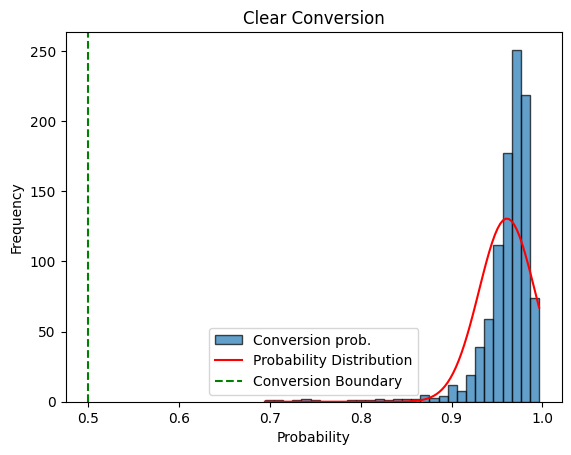

In [7]:
plot_prob_distr(observation_max, "Clear Conversion")

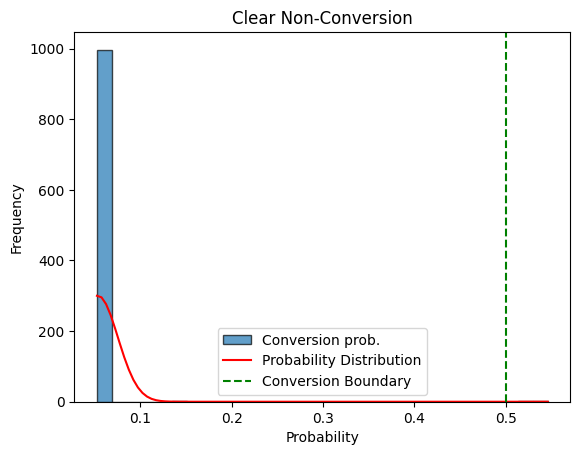

In [8]:
plot_prob_distr(observation_min, "Clear Non-Conversion")

In [16]:
observation_clearnonconv = dropout_predictions[:, 10]

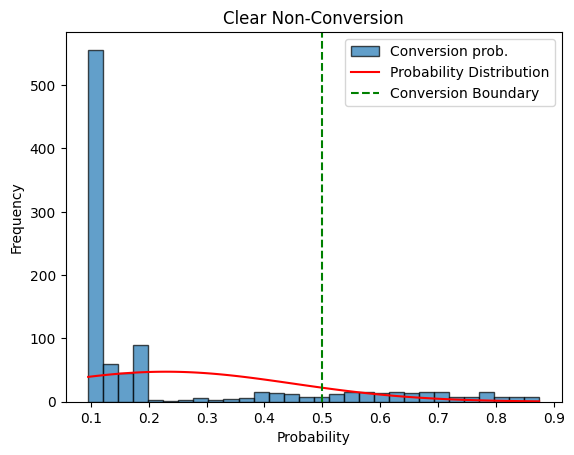

In [17]:
plot_prob_distr(observation_clearnonconv, "Clear Non-Conversion")

In [43]:
observation_boundary = dropout_predictions[:, 15]

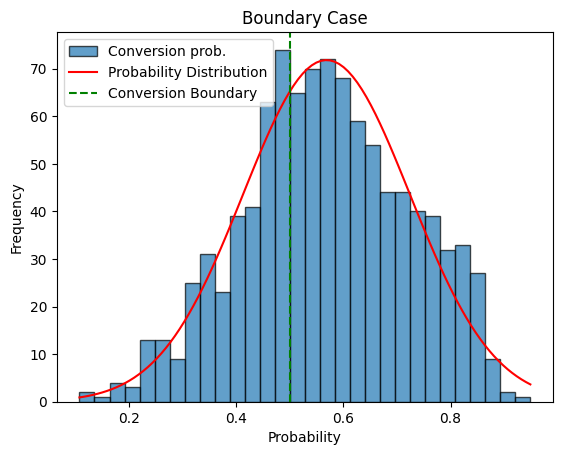

In [44]:
plot_prob_distr(observation_boundary, "Boundary Case")